In [4]:
import open3d as o3d
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt
import os
import cv2
import random
import sys
import math
import random
from time import sleep
import matplotlib.pyplot as plt
import copy
# monkey patches visualization and provides helpers to load geometries
#sys.path.append('..')
#import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
#o3dtut.interactive = not "CI" in os.environ

# RANSAC experiment

## Utilities

In [5]:
def find_hull(points):
    
    inliers_pcd = o3d.geometry.PointCloud()
    inliers_pcd.points = o3d.utility.Vector3dVector(points)
    #print(type(inliers_pcd))
    hull, _ = inliers_pcd.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    color = np.random.rand(3).tolist()
    hull_ls.paint_uniform_color(color)
    return hull_ls


In [6]:
def color_pts(points):
    inliers_pcd = o3d.geometry.PointCloud()
    inliers_pcd.points = o3d.utility.Vector3dVector(points)
    color = np.random.rand(3)
    #color = np.array([0,0,0])
    point_colors = np.tile(color, (points.shape[0],1))
    inliers_pcd.colors = o3d.utility.Vector3dVector(point_colors)
    return inliers_pcd

## Find plane

In [7]:
class plane:
    def __init__(self, M0, M1, M2):
        A0 = np.linalg.det(np.array([[M1[1]-M0[1],M2[1]-M0[1]],[M1[2]-M0[2],M2[2]-M0[2]]]))
        A1 = np.linalg.det(np.array([[M1[0]-M0[0],M2[0]-M0[0]],[M1[2]-M0[2],M2[2]-M0[2]]]))
        A2 = np.linalg.det(np.array([[M1[0]-M0[0],M2[0]-M0[0]],[M1[1]-M0[1],M2[1]-M0[1]]]))
        self.A = A0
        self.B = -A1
        self.C = A2
        self.D = -M0[0]*A0+M0[1]*A1-M0[2]*A2
    def calc_dist(self, pcd):
        #print(pcd[:,0].shape, self.A)
        R = np.absolute(self.A*pcd[:,0]+self.B*pcd[:,1]+self.C*pcd[:,2]+self.D)/(np.sqrt(self.A**2+self.B**2+self.C**2)+ sys.float_info.epsilon)
        #print(type(R))
        return R

In [8]:
def find_pts_plane(pcd):
    indexA = np.random.randint(0,pcd.shape[0])
    A = pcd[indexA]
    #print(A)
    distancesA = np.sqrt((pcd[:,0] - A[0])**2+(pcd[:,1] - A[1])**2+ (pcd[:,2] - A[2])**2)
    
    #Calculating B probabilities
    roundedA = np.around(distancesA,1)
    uniqueB, countsB = np.unique(roundedA, return_counts = True)
    probabilitiesB =1 - countsB/distancesA.shape[0]
    probabilitiesB /= probabilitiesB.sum()
    #plt.plot(uniqueB, probabilitiesB)
    #plt.show()
    choose_thresholded_value_B = np.random.choice(uniqueB, p=probabilitiesB)
    B_candidate_indices = np.argwhere(roundedA==choose_thresholded_value_B)
    B_candidate_indices = B_candidate_indices.reshape(B_candidate_indices.shape[0])
    indexB = np.random.choice(B_candidate_indices)
    B = pcd[indexB]
    #print(B)
    #print(np.sqrt((B[0] - A[0])**2+(B[1] - A[1])**2+ (B[2] - A[2])**2))
    
    pcd = np.delete(pcd, [indexA,indexB],0) 
    #pcd = np.delete(pcd, indexB,0)
   
    
    #Calculating C probabilities
    mid_AB = np.array([(A[0]+B[0])/2,(A[1]+B[1])/2,(A[2]+B[2])/2])
    distances_mid_AB = np.sqrt((pcd[:,0] - mid_AB[0])**2+(pcd[:,1] - mid_AB[1])**2+ (pcd[:,2] - mid_AB[2])**2)
    roundedAB = np.around(distances_mid_AB,1)
    uniqueC, countsC = np.unique(roundedAB, return_counts = True)
    probabilitiesC =1- countsC/distances_mid_AB.shape[0]
    
    probabilitiesC /= probabilitiesC.sum()
    #plt.plot(uniqueC, probabilitiesC)
    #plt.show()
    choose_thresholded_value_C = np.random.choice(uniqueC, p=probabilitiesC)
    C_candidate_indices = np.argwhere(roundedAB==choose_thresholded_value_C)
    C_candidate_indices = C_candidate_indices.reshape(C_candidate_indices.shape[0])
    indexC = np.random.choice(C_candidate_indices)
    C = pcd[indexC]
    #print(C)
    
    return A, B, C
   

In [9]:
def find_plane(pcd, iterations, threshold):
    best_fit = 0    ############## убрать костыль
    best_inliers_pts = np.zeros([1,3])
    best_inlier_indices = None
    inliers = None
    best_model = list()
    for i in range(iterations):
        A, B, C = find_pts_plane(np.asarray(pcd.points))
        p = plane(A,B,C)
        R = p.calc_dist(np.asarray(pcd.points))
        inliers = np.where(R<=threshold)[0]
        inliers_len = inliers.shape[0] +3
        inliers_pts = np.take(np.asarray(pcd.points),inliers,axis=0)
        outliers = np.asarray(pcd.points).shape[0] - inliers_len
        fit = inliers_len/outliers
        if fit>best_fit:
            best_fit = fit
            print('Found better fintess: ',best_fit, 'at', i )
            best_model = [A,B,C]
            best_inliers_pts = inliers_pts
            best_inlier_indices = inliers
    return best_model, best_inliers_pts, best_inlier_indices, p,best_fit

## Find sphere

In [10]:
class sphere:
    def __init__(self, p1, p2, v1, v2):
        
        self.center = 0
        self.radius = 0.001
        unit_v1 = v1 / np.linalg.norm(v1)
        unit_v2 = v2 / np.linalg.norm(v2)
        dot_product = np.dot(unit_v1, unit_v2)
        angle = np.degrees(np.arccos(dot_product))
        self.accept_shape = True
        a1 = np.dot(p2,v1)-np.dot(p1,v1)
        a2 = np.dot(p2,v2)-np.dot(p1,v2)
        b1 = np.dot(v2,v1)
        b2 = np.dot(v2,v2)
        c1 = np.dot(v1,v1)
        c2 = np.dot(v1,v2)
        A = np.array([[b1,-c1],[b2,-c2]])
        #print(A)
        B = np.array([-a1,-a2])
        #print('A=', A,'B=', B)
        try:
            C = np.linalg.solve(A,B)
            P = p1 + C[1]*v1
            Q = p2 + C[0]*v2
            self.center = (P+Q)/2
            r1 = np.linalg.norm(self.center-p1)
            r2 = np.linalg.norm(self.center-p2)
            self.radius = (r1+r2)/2
            self.accept_shape = True
        except:
            
            self.accept_shape = False
        #print(C)
        if angle>=120.0:
            self.accept_shape = False
            
        
        
        
    def calc_dist(self, pcd):
        #R = 
        R = np.linalg.norm(self.center-pcd, axis=-1)
        #print(R)
        #print(type(R))
        return R
    
    

In [11]:
def visualize_sphere(center,radius):
    sphere_mesh = o3d.geometry.TriangleMesh.create_sphere(radius, resolution = 20)
    
    sphere_mesh = sphere_mesh.translate(center)
    lineset = o3d.geometry.LineSet.create_from_triangle_mesh(sphere_mesh)
    return lineset

In [12]:
def find_pts_sphere(pcd):
    o3d.geometry.PointCloud.estimate_normals(
        pcd,
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,
                                                          max_nn=30))
    pcd1 = np.asarray(pcd.points)
    indexA = np.random.randint(0,pcd1.shape[0])
    A = pcd1[indexA]
    #print(A)
    distancesA = np.sqrt((pcd1[:,0] - A[0])**2+(pcd1[:,1] - A[1])**2+ (pcd1[:,2] - A[2])**2)
    
    #Calculating B probabilities
    roundedA = np.around(distancesA,1)
    uniqueB, countsB = np.unique(roundedA, return_counts = True)
    probabilitiesB =1 - countsB/distancesA.shape[0]
    probabilitiesB /= probabilitiesB.sum()
    #print(probabilitiesB)
    plt.plot(uniqueB, probabilitiesB)
    plt.show()
    choose_thresholded_value_B = np.random.choice(uniqueB, p=probabilitiesB)
    B_candidate_indices = np.argwhere(roundedA==choose_thresholded_value_B)
    B_candidate_indices = B_candidate_indices.reshape(B_candidate_indices.shape[0])
    indexB = np.random.choice(B_candidate_indices)
    B = pcd1[indexB]
    v1 = pcd.normals[indexA]
    v2 = pcd.normals[indexB]
    
    return A,B,v1,v2

In [13]:
def find_sphere(pcd, iterations, threshold):
    best_fit = 0
    best_inliers_pts = np.zeros
    best_inlier_indices = None
    inliers = None
    best_center = np.array((0,0,0))
    best_radius = 0.001
    angle = 0
    for j in range(iterations):
        #print(i)
        for i in range(5):
            p1,p2,v1,v2 = find_pts_sphere(pcd)
            s = sphere(p1,p2,v1,v2)
            
            if s.accept_shape==True:
                break
            
            print('Restart')
        #print(s.radius)
        R = s.calc_dist(np.asarray(pcd.points))
        #print(R)
        inliers = np.where((R<=s.radius+threshold) & (R>s.radius-threshold))[0] ################
        #inliers = R[R-s.radius-threshold-threshold/2.<threshold/2.]
        inliers_len = inliers.shape[0] +3
        #print(inliers)
        inliers_pts = np.take(np.asarray(pcd.points),inliers,axis=0)
        #print(inliers)
        outliers = np.asarray(pcd.points).shape[0] - inliers_len
        #print(outliers)
        fit = inliers_len/outliers
        if fit>best_fit:
            best_fit = fit
            print('Found better fintess: ',best_fit, 'at', j )
            best_center = s.center
            best_radius = s.radius
            best_inliers_pts = inliers_pts
            best_inlier_indices = inliers
    return best_center, best_radius, best_inliers_pts, best_inlier_indices

## Genetic algorithm tuning

In [14]:
class plane_GA:
    def __init__(self, A, B, C,D):
        #print(A)
        self.A = A
        self.B = B
        self.C = C
        self.D = D
    def calc_dist(self, pcd):
        #print(pcd[:,0].shape, self.A.shape)
        R = np.absolute(self.A*pcd[:,0]+self.B*pcd[:,1]+self.C*pcd[:,2]+self.D)/(np.sqrt(self.A**2+self.B**2+self.C**2)+ sys.float_info.epsilon)
        #print(type(R))
        return R

In [15]:
class GA_for_plane:
    def __init__(self):
        self.population=[]
        self.fitness =[]
        self.params = ['A', 'B', 'C', 'D']
        
    def init_popultation(self, size, A,B,C,D):
        #self.population=[]
        self.size = size
        for _ in range(self.size):
            rand_A = A + random.uniform(-1, 1)
            rand_B = B + random.uniform(-1, 1)
            rand_C = C + random.uniform(-1, 1)
            rand_D = D + random.uniform(-1, 1)
            self.population.append(plane_GA(rand_A,rand_B,rand_C,rand_D))
            
            
    def calc_fitness(self, pcd, threshold):
        self.fitness =[]
        #pcd = 
        for i in range(self.size):  
            distance = self.population[i].calc_dist(np.asarray(pcd.points))
            inliers = np.where(distance<=threshold)[0]
            inliers_len = inliers.shape[0] +3
            inliers_pts = np.take(np.asarray(pcd.points),inliers,axis=0)
            outliers = np.asarray(pcd.points).shape[0] - inliers_len
            fit = inliers_len/outliers
            self.fitness.append(fit)
            
        x = zip(self.fitness,self.population)
        xs = sorted(x,reverse = True, key=lambda tup: tup[0])
        self.fitness = [x[0] for x in xs]
        self.population = [x[1] for x in xs]
        #print(self.fitness)
        
    
        
        
    def selection(self):
        self.population = self.population[:int(len(self.population)/2)]
        
    
    def crossover(self, r1, r2):
        a = np.random.random(1)
        b = 1 - a
        
        A_new_1 = a * r1.A + b * r2.A
        B_new_1 = a * r1.B + b * r2.B
        C_new_1 = a * r1.C + b * r2.C
        D_new_1 = a * r1.D + b * r2.D
        self.plane_new_1 = plane_GA(A_new_1, B_new_1, C_new_1, D_new_1)
        a = 1 - a
        b = 1 - b
        A_new_2 = a * r1.A + b * r2.A
        B_new_2 = a * r1.B + b * r2.B
        C_new_2 = a * r1.C + b * r2.C
        D_new_2 = a * r1.D + b * r2.D
        self.plane_new_2 = plane_GA(A_new_2, B_new_2, C_new_2,D_new_2)
        
        return self.plane_new_1, self.plane_new_2
        
    def repopulate(self):
        self.offspring = []
        
        for _ in range(len(self.population)):
            population_indices = list(range(0,len(self.population)))
            index_1 = np.random.randint(0,len(self.population)-1,1)
            new_popultaion_indices = [el for el in population_indices if el != index_1]
            index_2 = random.choice(new_popultaion_indices)
            #print(index_2)
            child_1, child_2 = self.crossover(self.population[index_1[0]],self.population[index_2]) 
            self.offspring.append(child_1)
            #self.offspring.append(child_2)
        self.population = self.population + self.offspring
        
   
    def mutate1(self, mutation_rate):
        rng = default_rng()
        total_gen = len(self.population)*4
        mutation_chance = round(mutation_rate*total_gen)
        R_mutate_indices = rng.choice(len(self.population)*4, size=mutation_chance, replace=False)
        
        for i in R_mutate_indices:
            self.population[int(i/4)].__dict__[self.params[i%4]] += 1.2*(1-2*np.random.random(1)[0])
            
        
    
    def mutate_population(self):
        for i in range(len(self.population)):
            self.population[i] = self.mutate(self.population[i])

In [16]:
def genetic_tuning_plane(pcd, population_len, iterations, init_model, threshold, previous_fit):
    best_fit = previous_fit
    best_model = plane_GA(init_model[0],init_model[1],init_model[2],init_model[3])
    algorithm = GA_for_plane()
    #print(np.asarray(pcd.shape))
    algorithm.init_popultation(population_len,init_model[0],init_model[1],init_model[2], init_model[3])
    geometry_list = list()

    for _ in range(iterations):
        random.shuffle(algorithm.population)
        #print(algorithm.population)
        #for i in range(len(algorithm.population)):
        #    inliers = algorithm.population[i].check_pts(np.asarray(pcd.points))
        
        algorithm.calc_fitness(pcd, threshold)
        if algorithm.fitness[0]>best_fit:
            best_fit = algorithm.fitness[0]
            print('Found better fintess: ',best_fit, 'at', _ )
            best_model = algorithm.population[0]

        algorithm.selection()
        algorithm.repopulate()
        algorithm.mutate1(0.2)
        #algorithm.mutate_population()

        #vis.poll_events()
        #vis.update_renderer()
        #vis.clear_geometries()

    #experiments.append(best_fit)
    print('Best fitness:', best_fit)
    return best_model

In [17]:
def calc_inliers( model, pcd, threshold):
    distance = model.calc_dist(np.asarray(pcd.points))
    inliers = np.where(distance<=threshold)[0]
    inliers_len = inliers.shape[0] +3
    inliers_pts = np.take(np.asarray(pcd.points),inliers,axis=0)
    outliers = np.asarray(pcd.points).shape[0] - inliers_len
    return inliers, inliers_pts

## Main

PointCloud with 46514 points.


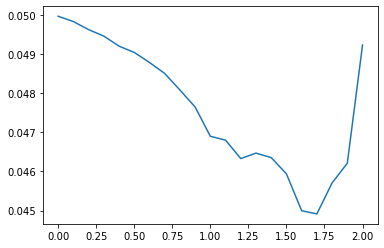

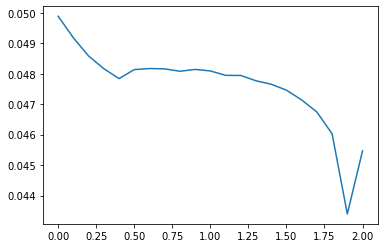

Found better fintess:  0.07034539890006213 at 1


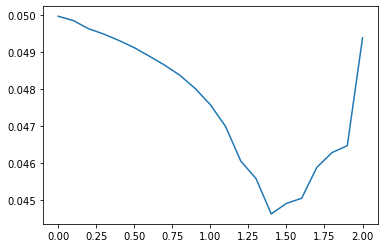

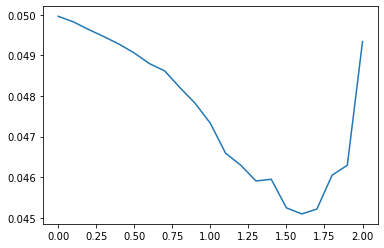

Found better fintess:  5.138841230038274 at 3


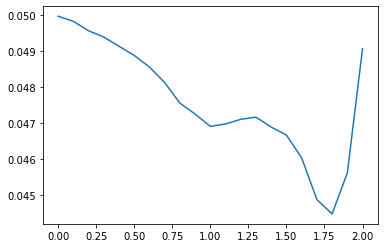

Found better fintess:  40.98014440433213 at 4


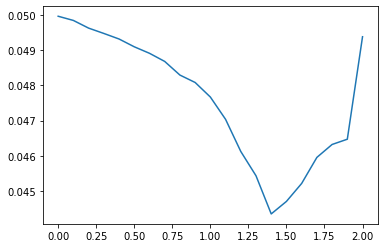

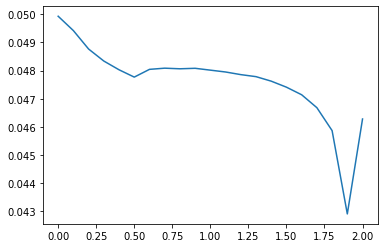

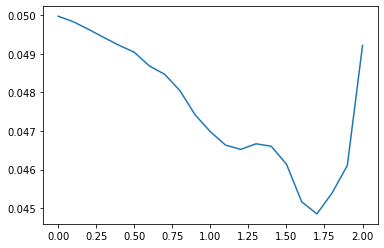

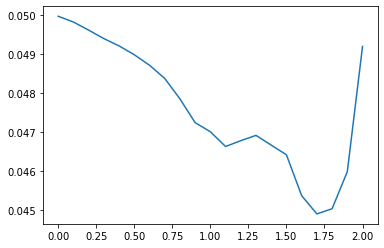

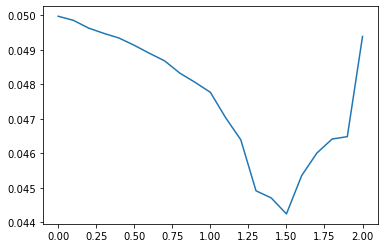

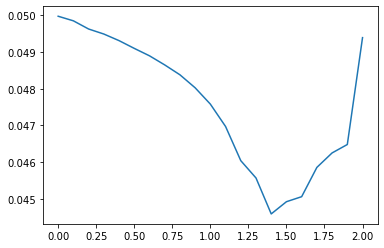

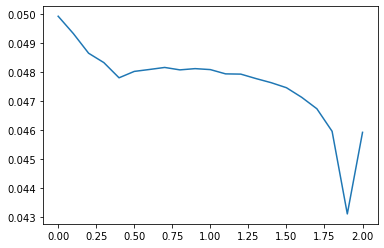

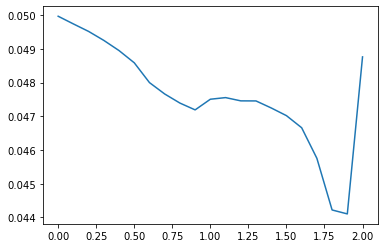

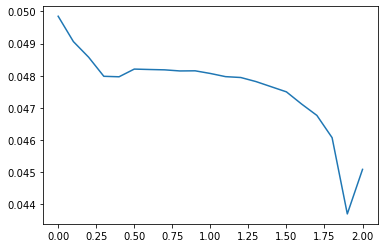

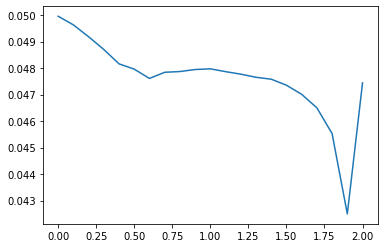

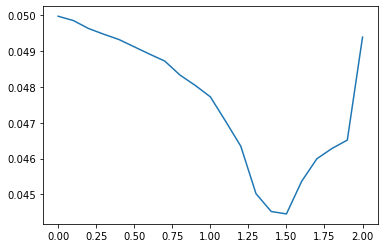

Restart


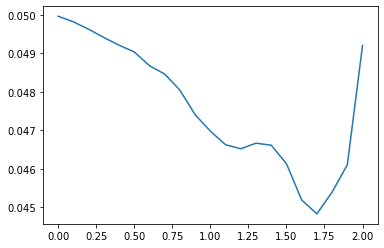

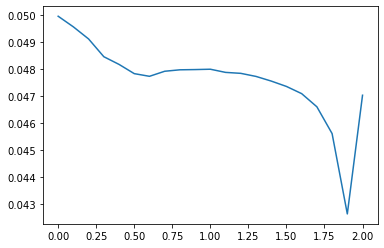

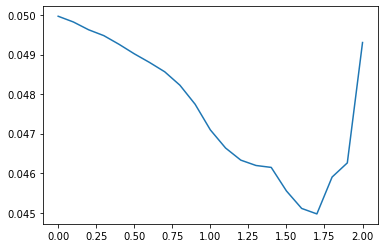

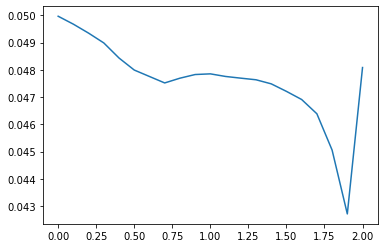

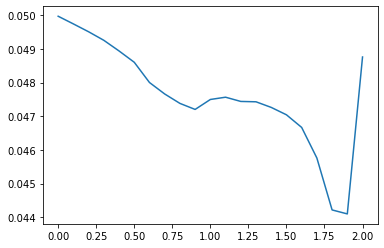

Restart


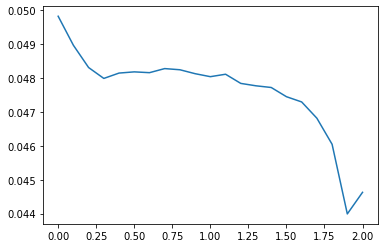

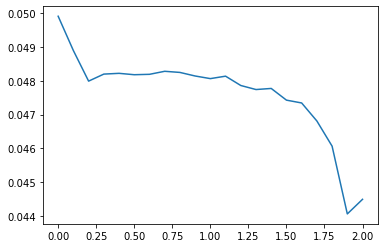

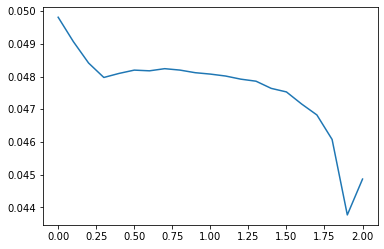

Restart


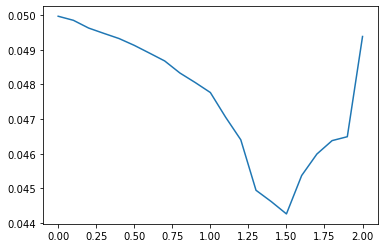

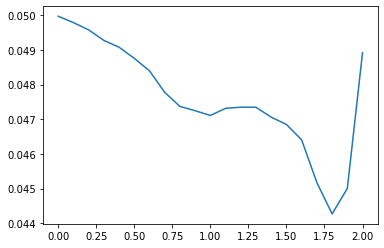

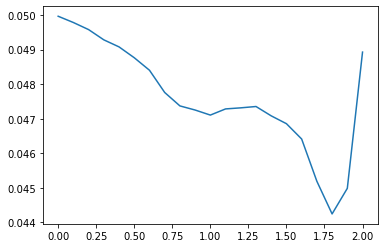

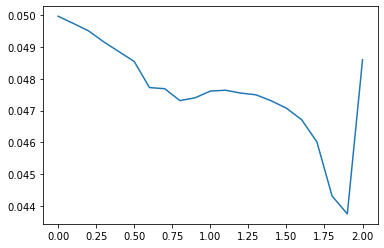

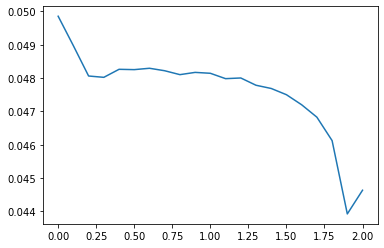

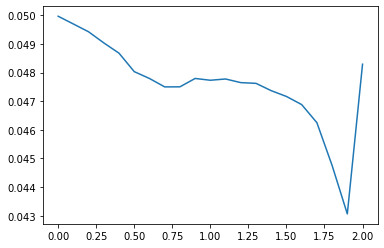

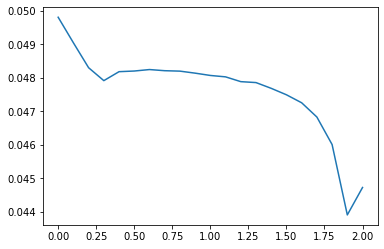

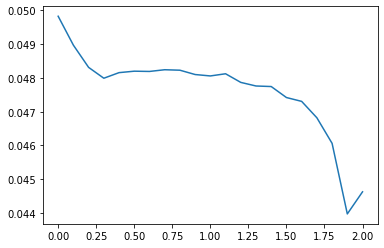

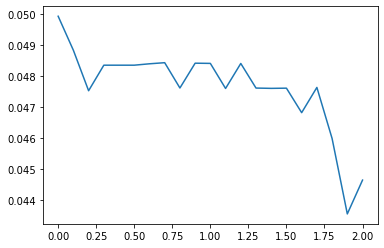

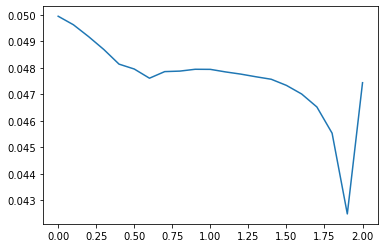

Restart


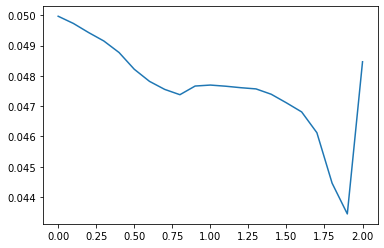

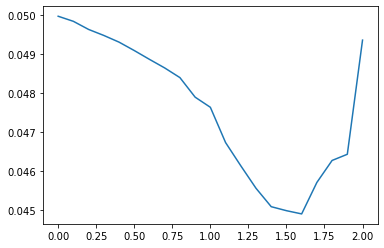

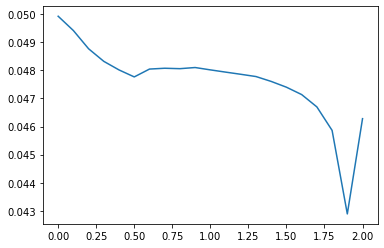

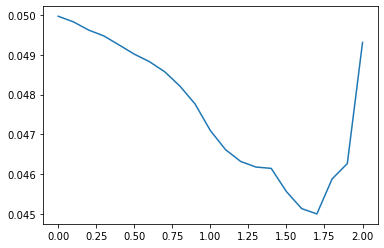

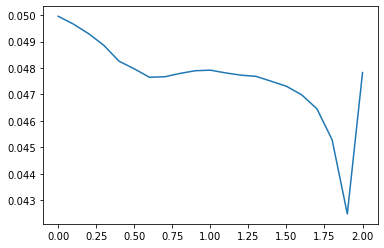

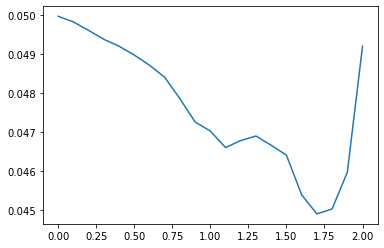

Restart


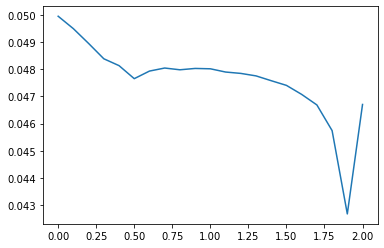

Restart


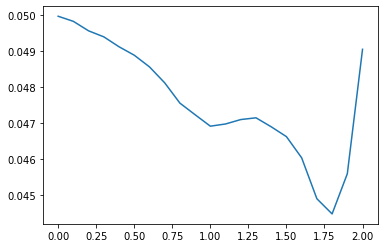

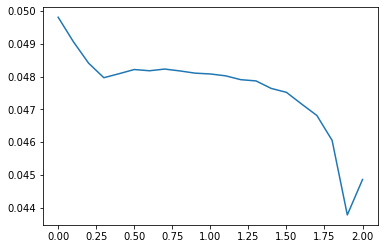

Restart


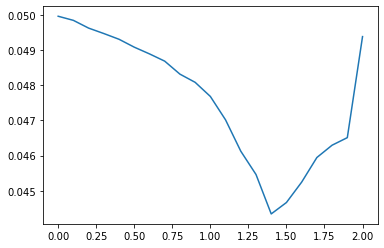

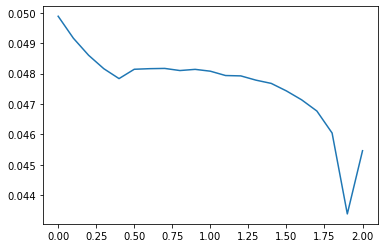

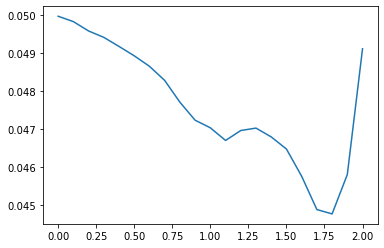

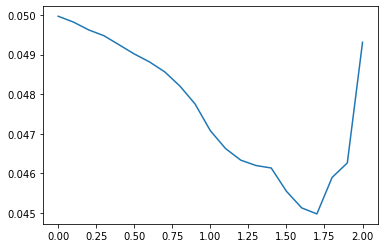

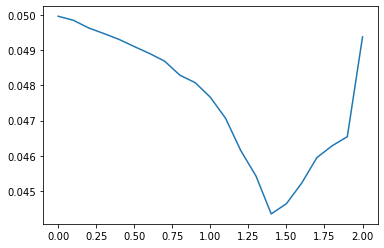

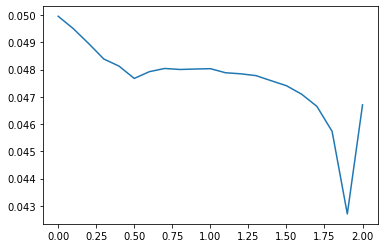

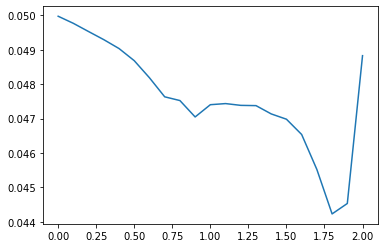

Restart


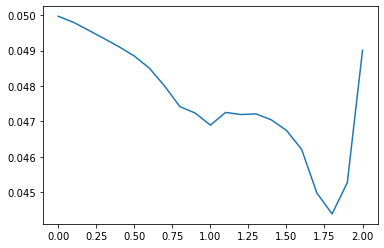

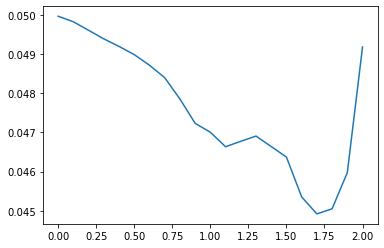

Restart


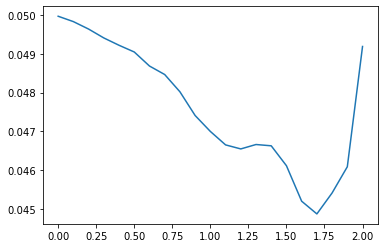

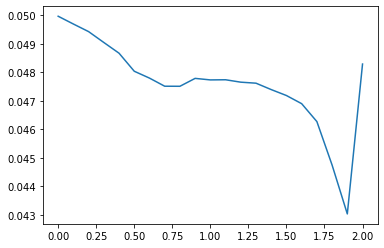

Restart


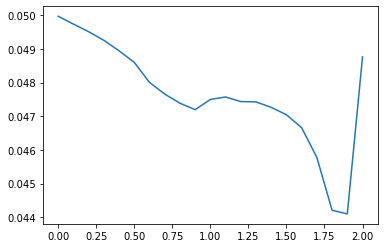

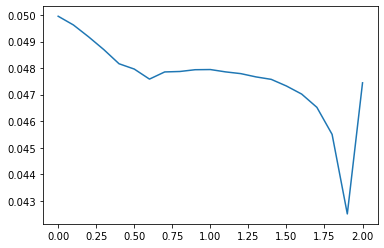

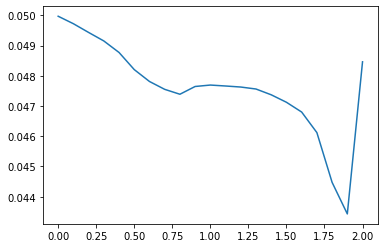

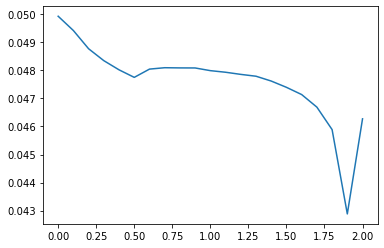

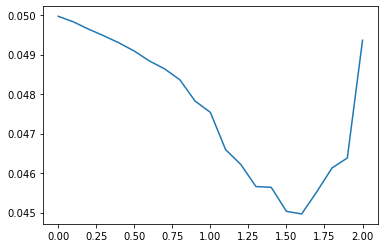

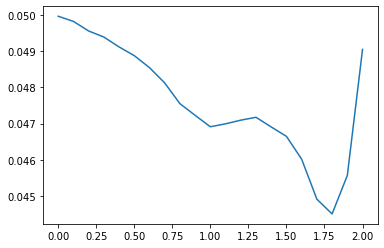

<ipython-input-18-81a24b14e520>:80: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  pcd1.colors = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd1.colors),inliers_indices,0) )


PointCloud with 1111 points.


In [18]:
#pcd = o3d.io.read_point_cloud("models/cube_test1.ply")
pcd = o3d.io.read_point_cloud("models/mball.ply")
#pcd = o3d.io.read_point_cloud("models/fragment.ply") 
#pcd = o3d.io.read_point_cloud("models/pcd.ply")
#pcd = o3d.io.read_point_cloud("models/apple.ply")
#pcd = o3d.io.read_point_cloud("models/ballcube.ply")
'''
color_raw = o3d.io.read_image("models/apple_1_1_12.png")
depth_raw = o3d.io.read_image("models/apple_1_1_12_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth)
plt.show()
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
o3d.io.write_point_cloud("models/copy_of_fragment.ply", pcd)
# Flip it, otherwise the pointcloud will be upside down
#pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
'''




vis = o3d.visualization.Visualizer()
vis.create_window(width = 800, height = 600)

colors_initial = pcd.colors
pcd1 = copy.deepcopy(pcd)
print(pcd)
models_list = []
inliers_list = []



'''
##find planar 
planes = []
for i in range(3):
    print('Ransac')
    model, inliers, inliers_indices, plane_found, first_fit = find_plane(pcd,70,0.015)
    #print(model)
    model_to_genetic = [plane_found.A, plane_found.B, plane_found.C, plane_found.D]
    print('GA')
    best_model1 = genetic_tuning_plane(pcd, 6,10, model_to_genetic,0.015,first_fit)
    #print(best_model1)
    ga_inliers_indices, ga_inliers_indices = calc_inliers(best_model1, pcd, 0.015)
    #print(best_model1.A)
    if inliers.shape[0]>15:
        pts = color_pts(inliers)
        vis.add_geometry(pts)
        pcd1.colors = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd1.colors),inliers_indices,0) )
        #pcd1.points = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.points), inliers_indices,0))
        pcd.points = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.points), inliers_indices,0))
        
        print(pcd)
#print(np.asarray(pcd.points).shape)

'''


##find spherical

for i in range(1):
    center, radius, inliers, inliers_indices = find_sphere(pcd,50,0.05)
    mesh = visualize_sphere(center,radius)
    vis.add_geometry(mesh)
    if type(inliers)!='NoneType':
        if inliers.shape[0]>0:
            
            pts = color_pts(inliers)
            vis.add_geometry(pts)
            pcd1.colors = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd1.colors),inliers_indices,0) )
            pcd.points = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.points), inliers_indices,0))
            print(pcd)




pcd.colors = pcd1.colors
vis.add_geometry(pcd)
#color = np.array([0,0,0])
#point_colors = np.tile(color, (np.asarray(pcd.points).shape[0],1))
#colors = o3d.utility.Vector3dVector(point_colors)
#point_colors = np.tile(color, (points.shape[0],1))
#pcd.colors = o3d.utility.Vector3dVector(point_colors)
vis.run()
vis.destroy_window()

In [42]:
pcd = o3d.io.read_point_cloud("models/pcd.ply")
#bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(0, 0, -5), max_bound=(5, 5, 5))
#cropped = bbox.crop_point_cloud(pcd)
o3d.geometry.PointCloud.estimate_normals(
        pcd,
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,
                                                          max_nn=30))

vis = o3d.visualization.Visualizer()
vis.create_window(width = 800, height = 600)
vis.add_geometry(pcd)
vis.run()
vis.destroy_window()

In [43]:
np.asarpcd1.colors

AttributeError: module 'numpy' has no attribute 'asarpcd1'